# ACGAN

In [1]:
import numpy as np
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Embedding, Activation, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=in_shape)
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	fe = Flatten()(fe)
	out1 = Dense(1, activation='sigmoid')(fe)
	out2 = Dense(n_classes, activation='softmax')(fe)
	model = Model(in_image, [out1, out2])
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                              

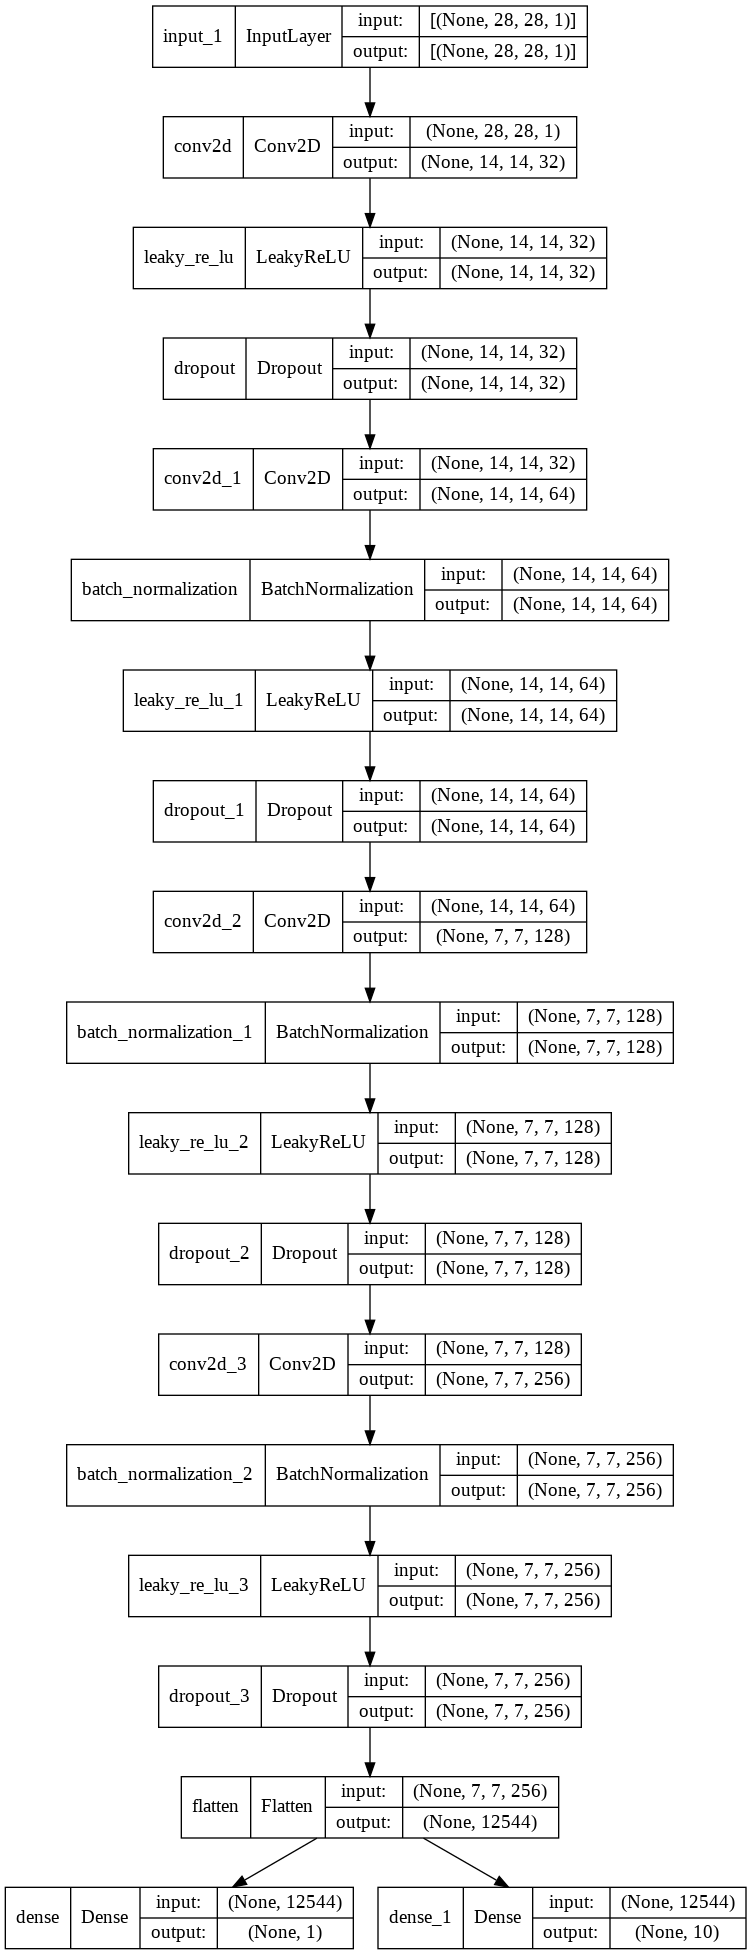

In [3]:
discriminator_model = define_discriminator()
discriminator_model.summary()
plot_model(discriminator_model, to_file = 'discriminator_model.png', show_shapes = True, show_layer_names = True)

In [4]:
def define_generator(latent_dim, n_classes=10):
	init = RandomNormal(stddev=0.02)
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 7 * 7
	li = Dense(n_nodes, kernel_initializer=init)(li)
	li = Reshape((7, 7, 1))(li)
	in_lat = Input(shape=(latent_dim,))
	n_nodes = 384 * 7 * 7
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((7, 7, 384))(gen)
	merge = Concatenate()([gen, li])
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	model = Model([in_lat, in_label], out_layer)
	return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

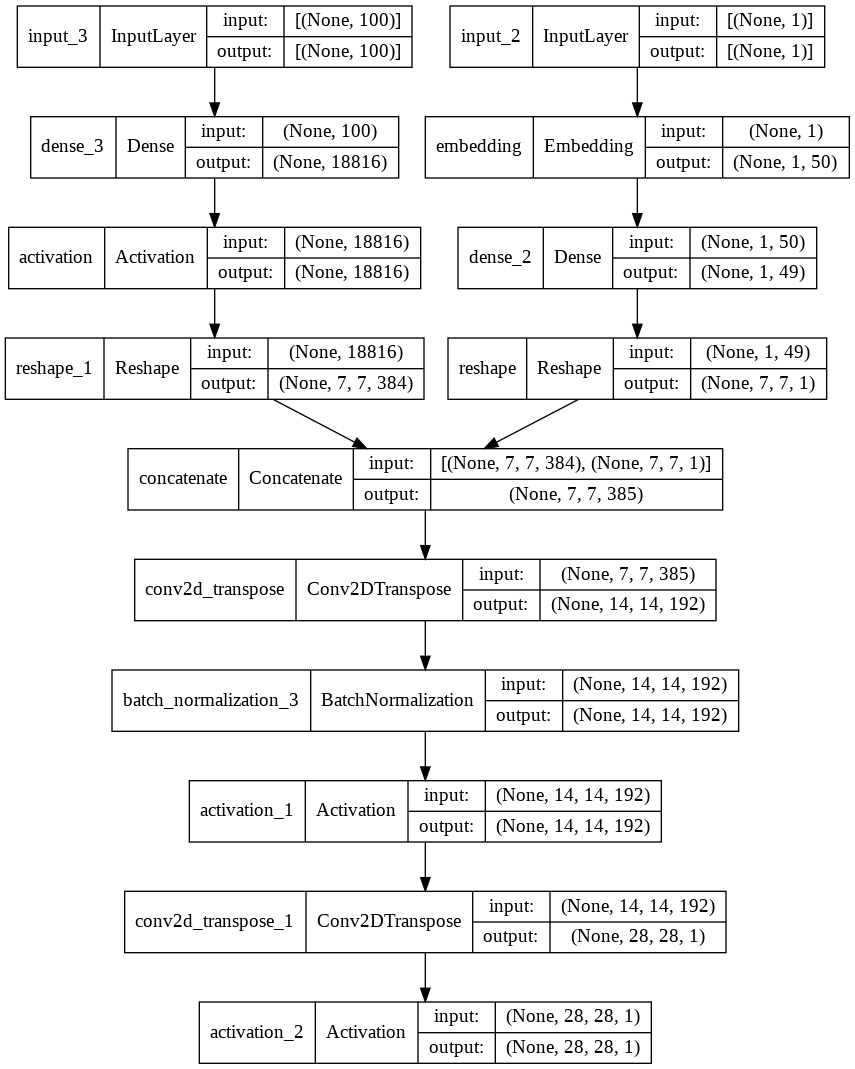

In [5]:
latent_dim = 100
generator_model = define_generator(latent_dim)
generator_model.summary()
plot_model(generator_model, to_file = 'generator_model.png', show_shapes = True, show_layer_names = True)

In [6]:
def define_gan(g_model, d_model):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	gan_output = d_model(g_model.output)
	model = Model(g_model.input, gan_output)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 18816)        1900416     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

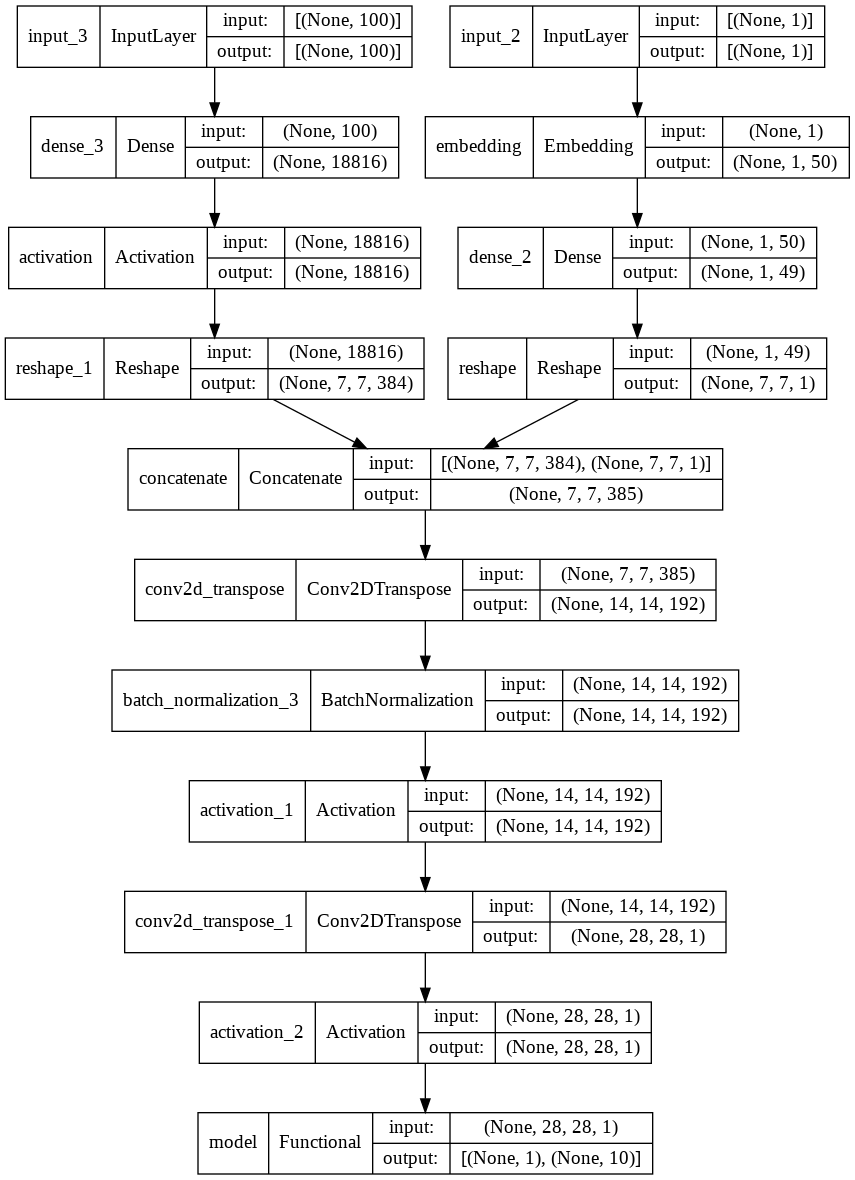

In [7]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()
plot_model(gan_model, to_file = 'gan_model.png', show_layer_names = True, show_shapes = True)

In [8]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X = np.expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = np.random.randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [9]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [10]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.show()
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('=> Saved: %s and %s' % (filename1, filename2))

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  n_steps = bat_per_epo * n_epochs
  half_batch = int(n_batch / 2)
  print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
  for i in range(n_steps):
    [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
    _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
    y_gan = np.ones((n_batch, 1))
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
    if (i+1) in (1, n_steps) or (i+1) % 100 == 0:
      print('> Step %d: dr[%.3f, %.3f], df[%.3f, %.3f], g[%.3f, %.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, latent_dim)

In [12]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)

In [13]:
dataset = load_real_samples()

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)


n_epochs=100, n_batch=64, 1/2=32, b/e=937, steps=93700
> Step 1: dr[0.882, 2.845], df[1.689, 3.531], g[0.667, 3.337]
> Step 100: dr[0.192, 0.956], df[0.102, 3.173], g[0.084, 2.832]
> Step 200: dr[0.087, 1.118], df[0.084, 0.239], g[0.094, 0.213]
> Step 300: dr[0.848, 1.258], df[0.344, 0.048], g[1.797, 0.264]
> Step 400: dr[0.630, 1.221], df[0.579, 0.048], g[1.833, 0.083]
> Step 500: dr[0.463, 0.717], df[0.137, 0.073], g[2.647, 0.130]
> Step 600: dr[0.096, 0.808], df[0.060, 0.134], g[3.469, 0.124]
> Step 700: dr[0.502, 0.450], df[0.360, 0.037], g[1.473, 0.081]
> Step 800: dr[0.410, 1.069], df[0.665, 0.127], g[2.865, 0.185]
> Step 900: dr[0.413, 0.794], df[0.214, 0.028], g[1.625, 0.087]
> Step 1000: dr[0.068, 0.451], df[0.179, 0.045], g[3.267, 0.146]
> Step 1100: dr[0.902, 0.676], df[0.609, 0.021], g[2.133, 0.214]
> Step 1200: dr[0.774, 0.684], df[0.444, 0.067], g[1.518, 0.066]
> Step 1300: dr[0.307, 0.598], df[0.559, 0.195], g[1.975, 0.117]
> Step 1400: dr[0.364, 0.579], df[0.197, 0.150]

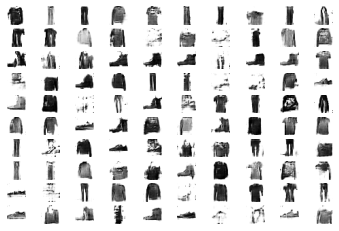

=> Saved: generated_plot_9370.png and model_9370.h5
> Step 9400: dr[0.703, 0.492], df[0.725, 0.049], g[0.823, 0.033]
> Step 9500: dr[0.626, 0.554], df[0.725, 0.019], g[0.969, 0.068]
> Step 9600: dr[0.685, 0.339], df[0.667, 0.012], g[0.852, 0.090]
> Step 9700: dr[0.716, 0.395], df[0.686, 0.037], g[0.887, 0.031]
> Step 9800: dr[0.640, 0.407], df[0.764, 0.041], g[0.808, 0.022]
> Step 9900: dr[0.777, 0.505], df[0.735, 0.067], g[0.821, 0.036]
> Step 10000: dr[0.589, 0.716], df[0.654, 0.059], g[0.971, 0.040]
> Step 10100: dr[0.780, 0.472], df[0.681, 0.037], g[0.894, 0.026]
> Step 10200: dr[0.636, 0.768], df[0.804, 0.009], g[0.944, 0.033]
> Step 10300: dr[0.634, 0.363], df[0.846, 0.059], g[0.742, 0.025]
> Step 10400: dr[0.632, 0.616], df[0.715, 0.042], g[0.873, 0.036]
> Step 10500: dr[0.585, 0.262], df[0.701, 0.025], g[0.847, 0.031]
> Step 10600: dr[0.602, 0.290], df[0.713, 0.026], g[0.854, 0.046]
> Step 10700: dr[0.602, 0.396], df[0.679, 0.028], g[0.782, 0.021]
> Step 10800: dr[0.611, 0.782]

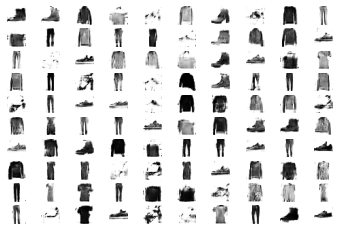

=> Saved: generated_plot_18740.png and model_18740.h5
> Step 18800: dr[0.672, 0.490], df[0.714, 0.019], g[0.764, 0.020]
> Step 18900: dr[0.719, 0.527], df[0.721, 0.015], g[0.698, 0.014]
> Step 19000: dr[0.694, 0.126], df[0.730, 0.010], g[0.712, 0.010]
> Step 19100: dr[0.688, 0.335], df[0.635, 0.022], g[0.709, 0.011]
> Step 19200: dr[0.652, 0.363], df[0.718, 0.012], g[0.747, 0.017]
> Step 19300: dr[0.722, 0.695], df[0.719, 0.012], g[0.760, 0.015]
> Step 19400: dr[0.673, 0.272], df[0.725, 0.031], g[0.709, 0.023]
> Step 19500: dr[0.729, 0.348], df[0.670, 0.025], g[0.739, 0.016]
> Step 19600: dr[0.685, 0.486], df[0.717, 0.017], g[0.708, 0.021]
> Step 19700: dr[0.689, 0.606], df[0.723, 0.030], g[0.744, 0.022]
> Step 19800: dr[0.691, 0.799], df[0.717, 0.043], g[0.720, 0.020]
> Step 19900: dr[0.669, 0.243], df[0.676, 0.014], g[0.747, 0.023]
> Step 20000: dr[0.680, 0.296], df[0.700, 0.010], g[0.705, 0.022]
> Step 20100: dr[0.733, 0.314], df[0.692, 0.018], g[0.697, 0.016]
> Step 20200: dr[0.672

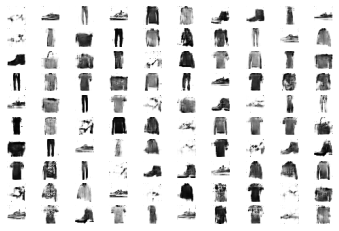

=> Saved: generated_plot_28110.png and model_28110.h5
> Step 28200: dr[0.704, 0.330], df[0.719, 0.013], g[0.718, 0.014]
> Step 28300: dr[0.685, 0.316], df[0.690, 0.008], g[0.735, 0.019]
> Step 28400: dr[0.700, 0.639], df[0.703, 0.028], g[0.712, 0.012]
> Step 28500: dr[0.671, 0.381], df[0.726, 0.017], g[0.735, 0.025]
> Step 28600: dr[0.734, 1.085], df[0.728, 0.022], g[0.718, 0.014]
> Step 28700: dr[0.712, 0.293], df[0.714, 0.038], g[0.724, 0.012]
> Step 28800: dr[0.708, 0.767], df[0.701, 0.009], g[0.727, 0.012]
> Step 28900: dr[0.676, 0.702], df[0.703, 0.008], g[0.736, 0.014]
> Step 29000: dr[0.681, 0.348], df[0.715, 0.023], g[0.671, 0.016]
> Step 29100: dr[0.714, 0.873], df[0.672, 0.013], g[0.708, 0.041]
> Step 29200: dr[0.693, 0.550], df[0.718, 0.010], g[0.710, 0.010]
> Step 29300: dr[0.705, 0.556], df[0.660, 0.020], g[0.693, 0.010]
> Step 29400: dr[0.702, 0.309], df[0.704, 0.012], g[0.704, 0.012]
> Step 29500: dr[0.711, 0.303], df[0.724, 0.013], g[0.716, 0.018]
> Step 29600: dr[0.662

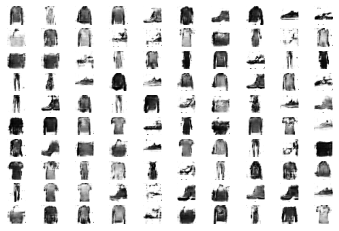

=> Saved: generated_plot_37480.png and model_37480.h5
> Step 37500: dr[0.646, 0.292], df[0.728, 0.013], g[0.681, 0.009]
> Step 37600: dr[0.743, 0.189], df[0.714, 0.028], g[0.729, 0.011]
> Step 37700: dr[0.717, 0.248], df[0.727, 0.013], g[0.692, 0.007]
> Step 37800: dr[0.747, 0.376], df[0.733, 0.013], g[0.714, 0.012]
> Step 37900: dr[0.746, 0.410], df[0.727, 0.007], g[0.721, 0.032]
> Step 38000: dr[0.710, 0.711], df[0.695, 0.011], g[0.712, 0.009]
> Step 38100: dr[0.676, 0.443], df[0.712, 0.028], g[0.715, 0.012]
> Step 38200: dr[0.689, 0.637], df[0.715, 0.020], g[0.731, 0.015]
> Step 38300: dr[0.671, 0.396], df[0.735, 0.019], g[0.696, 0.012]
> Step 38400: dr[0.709, 0.369], df[0.690, 0.023], g[0.724, 0.010]
> Step 38500: dr[0.693, 0.637], df[0.722, 0.012], g[0.704, 0.016]
> Step 38600: dr[0.681, 0.525], df[0.715, 0.017], g[0.745, 0.014]
> Step 38700: dr[0.695, 0.348], df[0.697, 0.011], g[0.739, 0.009]
> Step 38800: dr[0.728, 0.536], df[0.710, 0.010], g[0.716, 0.016]
> Step 38900: dr[0.704

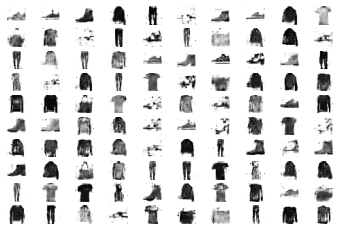

=> Saved: generated_plot_46850.png and model_46850.h5
> Step 46900: dr[0.670, 0.409], df[0.704, 0.018], g[0.718, 0.017]
> Step 47000: dr[0.715, 0.474], df[0.692, 0.009], g[0.707, 0.010]
> Step 47100: dr[0.716, 0.541], df[0.712, 0.011], g[0.720, 0.015]
> Step 47200: dr[0.691, 0.269], df[0.721, 0.012], g[0.714, 0.010]
> Step 47300: dr[0.667, 0.493], df[0.680, 0.011], g[0.700, 0.011]
> Step 47400: dr[0.737, 0.402], df[0.732, 0.011], g[0.719, 0.017]
> Step 47500: dr[0.668, 0.266], df[0.727, 0.029], g[0.709, 0.008]
> Step 47600: dr[0.732, 0.240], df[0.736, 0.008], g[0.689, 0.013]
> Step 47700: dr[0.710, 0.627], df[0.736, 0.014], g[0.697, 0.011]
> Step 47800: dr[0.709, 0.826], df[0.709, 0.018], g[0.679, 0.018]
> Step 47900: dr[0.669, 0.463], df[0.715, 0.010], g[0.738, 0.021]
> Step 48000: dr[0.683, 0.823], df[0.685, 0.011], g[0.689, 0.016]
> Step 48100: dr[0.683, 0.369], df[0.703, 0.016], g[0.713, 0.011]
> Step 48200: dr[0.655, 0.143], df[0.714, 0.007], g[0.703, 0.016]
> Step 48300: dr[0.707

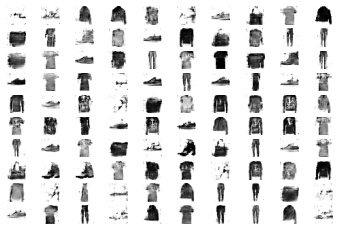

=> Saved: generated_plot_56220.png and model_56220.h5
> Step 56300: dr[0.631, 0.150], df[0.714, 0.008], g[0.698, 0.015]
> Step 56400: dr[0.711, 0.188], df[0.691, 0.008], g[0.706, 0.013]
> Step 56500: dr[0.679, 0.398], df[0.686, 0.005], g[0.696, 0.019]
> Step 56600: dr[0.695, 0.453], df[0.740, 0.008], g[0.719, 0.007]
> Step 56700: dr[0.707, 0.669], df[0.676, 0.017], g[0.726, 0.013]
> Step 56800: dr[0.686, 0.286], df[0.691, 0.007], g[0.681, 0.015]
> Step 56900: dr[0.731, 0.381], df[0.722, 0.013], g[0.705, 0.012]
> Step 57000: dr[0.717, 0.476], df[0.669, 0.015], g[0.693, 0.014]
> Step 57100: dr[0.716, 0.416], df[0.728, 0.037], g[0.705, 0.016]
> Step 57200: dr[0.711, 0.318], df[0.725, 0.010], g[0.711, 0.010]
> Step 57300: dr[0.690, 0.477], df[0.706, 0.021], g[0.695, 0.010]
> Step 57400: dr[0.740, 0.506], df[0.717, 0.009], g[0.716, 0.013]
> Step 57500: dr[0.720, 0.388], df[0.655, 0.023], g[0.718, 0.015]
> Step 57600: dr[0.700, 0.521], df[0.727, 0.025], g[0.736, 0.010]
> Step 57700: dr[0.621

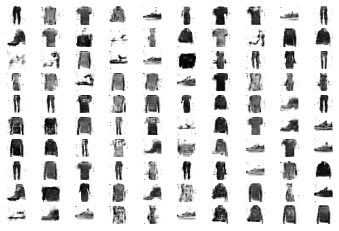

=> Saved: generated_plot_65590.png and model_65590.h5
> Step 65600: dr[0.681, 0.582], df[0.642, 0.004], g[0.713, 0.008]
> Step 65700: dr[0.745, 0.392], df[0.691, 0.007], g[0.737, 0.007]
> Step 65800: dr[0.733, 0.465], df[0.665, 0.036], g[0.694, 0.012]
> Step 65900: dr[0.691, 0.310], df[0.698, 0.020], g[0.723, 0.017]
> Step 66000: dr[0.701, 0.300], df[0.687, 0.008], g[0.733, 0.006]
> Step 66100: dr[0.717, 0.469], df[0.735, 0.006], g[0.724, 0.017]
> Step 66200: dr[0.692, 0.534], df[0.727, 0.010], g[0.713, 0.023]
> Step 66300: dr[0.708, 0.277], df[0.689, 0.006], g[0.735, 0.012]
> Step 66400: dr[0.697, 0.249], df[0.688, 0.007], g[0.688, 0.017]
> Step 66500: dr[0.689, 0.584], df[0.709, 0.009], g[0.697, 0.014]
> Step 66600: dr[0.695, 0.324], df[0.682, 0.005], g[0.729, 0.015]
> Step 66700: dr[0.666, 0.807], df[0.724, 0.008], g[0.726, 0.014]
> Step 66800: dr[0.647, 0.264], df[0.723, 0.018], g[0.686, 0.011]
> Step 66900: dr[0.697, 0.506], df[0.722, 0.011], g[0.707, 0.008]
> Step 67000: dr[0.692

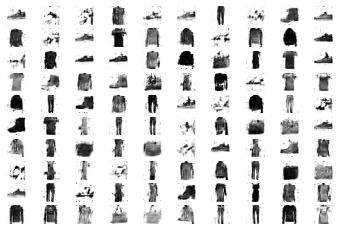

=> Saved: generated_plot_74960.png and model_74960.h5
> Step 75000: dr[0.690, 0.593], df[0.707, 0.015], g[0.702, 0.038]
> Step 75100: dr[0.722, 0.919], df[0.702, 0.007], g[0.743, 0.011]
> Step 75200: dr[0.677, 0.356], df[0.718, 0.009], g[0.695, 0.016]
> Step 75300: dr[0.736, 0.697], df[0.691, 0.008], g[0.668, 0.009]
> Step 75400: dr[0.721, 0.346], df[0.702, 0.007], g[0.696, 0.023]
> Step 75500: dr[0.687, 0.370], df[0.713, 0.018], g[0.703, 0.012]
> Step 75600: dr[0.685, 0.233], df[0.708, 0.011], g[0.678, 0.008]
> Step 75700: dr[0.696, 0.444], df[0.637, 0.019], g[0.712, 0.018]
> Step 75800: dr[0.733, 0.379], df[0.750, 0.012], g[0.717, 0.012]
> Step 75900: dr[0.680, 0.433], df[0.682, 0.009], g[0.719, 0.012]
> Step 76000: dr[0.715, 0.245], df[0.712, 0.010], g[0.722, 0.008]
> Step 76100: dr[0.705, 0.553], df[0.739, 0.012], g[0.720, 0.013]
> Step 76200: dr[0.729, 0.496], df[0.718, 0.006], g[0.718, 0.007]
> Step 76300: dr[0.703, 0.285], df[0.723, 0.009], g[0.708, 0.011]
> Step 76400: dr[0.715

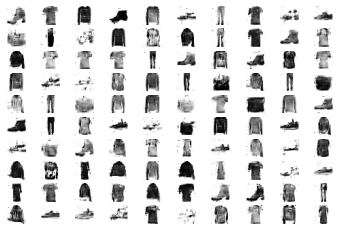

=> Saved: generated_plot_84330.png and model_84330.h5
> Step 84400: dr[0.707, 0.331], df[0.760, 0.006], g[0.760, 0.014]
> Step 84500: dr[0.742, 0.452], df[0.719, 0.005], g[0.728, 0.011]
> Step 84600: dr[0.726, 0.321], df[0.758, 0.012], g[0.706, 0.007]
> Step 84700: dr[0.718, 0.797], df[0.751, 0.010], g[0.722, 0.011]
> Step 84800: dr[0.695, 0.650], df[0.749, 0.013], g[0.698, 0.011]
> Step 84900: dr[0.690, 0.256], df[0.700, 0.012], g[0.721, 0.012]
> Step 85000: dr[0.704, 0.308], df[0.707, 0.006], g[0.725, 0.017]
> Step 85100: dr[0.635, 0.634], df[0.710, 0.004], g[0.683, 0.009]
> Step 85200: dr[0.744, 0.521], df[0.683, 0.006], g[0.724, 0.043]
> Step 85300: dr[0.691, 0.236], df[0.725, 0.008], g[0.696, 0.018]
> Step 85400: dr[0.649, 0.579], df[0.766, 0.012], g[0.710, 0.018]
> Step 85500: dr[0.694, 0.385], df[0.723, 0.007], g[0.682, 0.016]
> Step 85600: dr[0.695, 0.260], df[0.734, 0.009], g[0.706, 0.006]
> Step 85700: dr[0.742, 0.557], df[0.678, 0.012], g[0.703, 0.012]
> Step 85800: dr[0.699

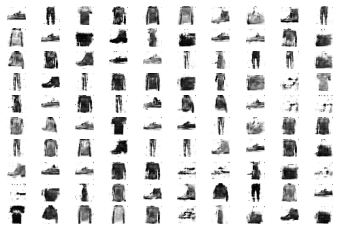

=> Saved: generated_plot_93700.png and model_93700.h5


In [14]:
train(generator, discriminator, gan_model, dataset, latent_dim)

In [17]:
from math import sqrt
from keras.models import load_model

def fashion_class(i):
	switcher={
		0: 'T-shirt/top',
		1: 'Trouser',
		2: 'Pullover',
		3: 'Dress',
		4: 'Coat',
		5: 'Sandal',
		6: 'Shirt',
		7: 'Sneaker',
		8: 'Bag',
		9: 'Ankle boot'
	}
	return switcher.get(i,"Invalid class")


def generate_latent_points(latent_dim, n_samples, n_class):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = np.asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]

def save_plot(examples, n_examples):
	for i in range(n_examples):
		plt.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

T-shirt/top


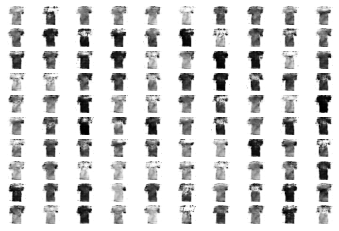

Trouser


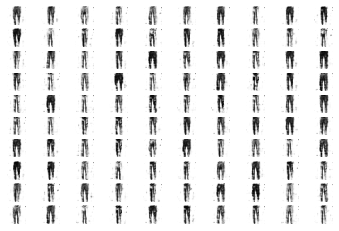

Pullover


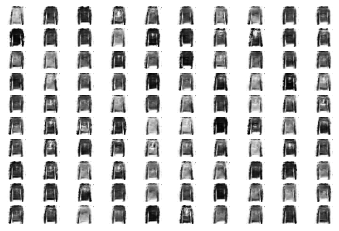

Dress


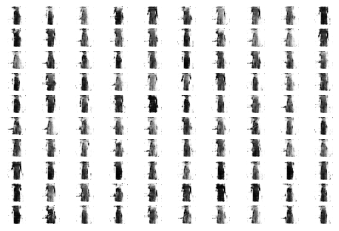

Coat


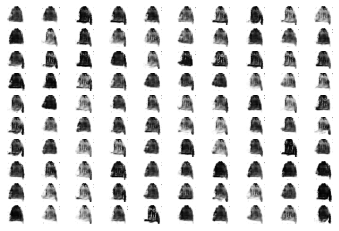

Sandal


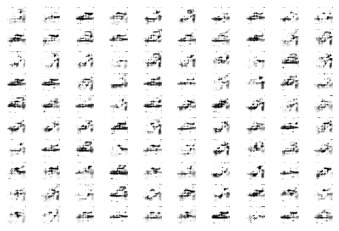

Shirt


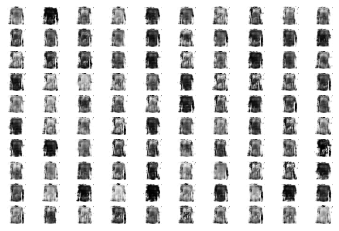

Sneaker


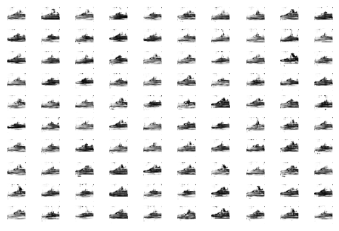

Bag


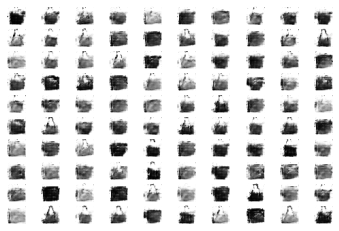

Ankle boot


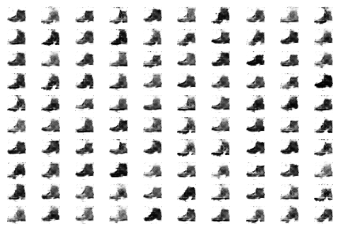

In [18]:
model = load_model('model_93700.h5')
latent_dim = 100
n_examples = 100
n_classes = 10
for i in range(n_classes):
  latent_points, labels = generate_latent_points(latent_dim, n_examples, i)
  X = model.predict([latent_points, labels])
  X = (X + 1) / 2.0
  print(fashion_class(i))
  save_plot(X, n_examples)